In [1]:
# Use the library function to load the R packages
library(tidyverse)
library(repr)
library(readxl)
library(cowplot)
library(RColorBrewer)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ──────────────────────

In [10]:
# Read the CSV file
student_data_hypo <- read_csv("student.csv", col_names = TRUE, show_col_types = FALSE) |>
    select(Mothers_Education, Fathers_Education, CGPA_Last_Semester) |>
    mutate(high_education_family = if_else(Mothers_Education > 3 | Fathers_Education > 3, "High", "Low"), 
          academically_successful = if_else(CGPA_Last_Semester > 3, "successful", "unsuccessful"))
head(student_data_hypo, 5)

Mothers_Education,Fathers_Education,CGPA_Last_Semester,high_education_family,academically_successful
<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,2,1,Low,unsuccessful
2,3,2,Low,unsuccessful
2,2,2,Low,unsuccessful
1,2,3,Low,unsuccessful
3,3,2,Low,unsuccessful


first we will conduct a hypothesis test with the hypotheses 
$$
H_0: p_h - p_l = 0\\
h_A: p_h - p_l \neq 0
$$
To do this we will obtain the null distribution, and the observed difference in proportions. Then we will use these to obtain the p-value. We will be assessing the p-value using a significance level of 0.05.

stat
<dbl>
-0.009119927


p_value
<dbl>
0.606


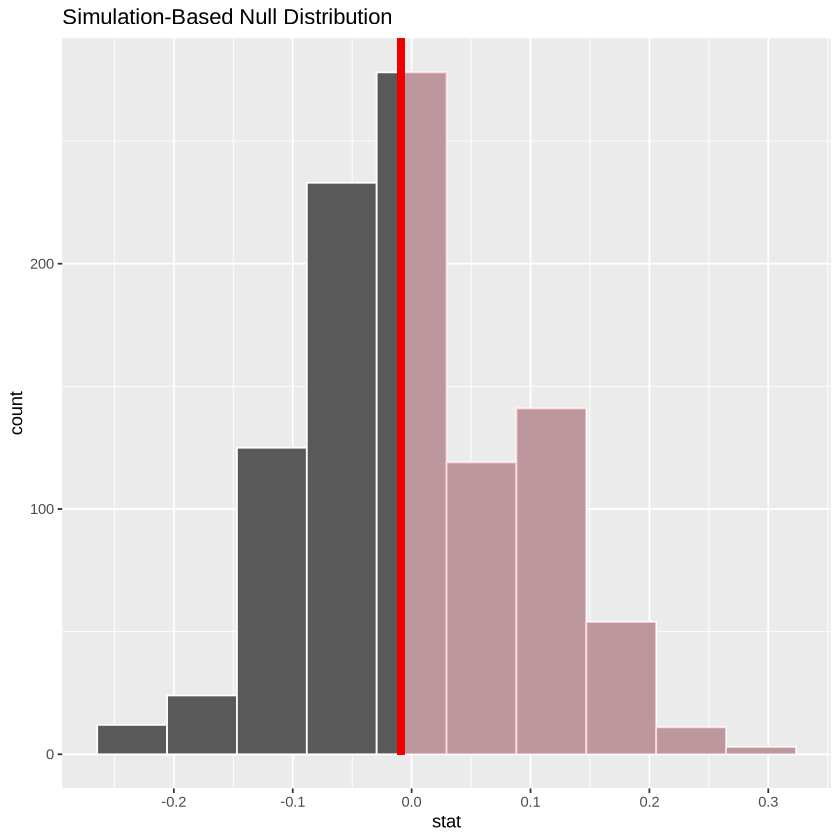

In [12]:
#Obtain the null distribution
null_dist <- student_data_hypo |>
    specify(academically_successful ~ high_education_family, success = "successful") |>
    hypothesize(null = "independence") |>
    generate(reps = 1000, type = "permute") |>
    calculate(stat = "diff in props", order = c("High","Low"))
#Find the difference in proportions of high and low education families that are academically successful
obs_diff_props <- student_data_hypo |>
    specify(academically_successful ~ high_education_family, success = "successful") |>
    calculate(stat = "diff in props", order = c("High","Low"))
#visualize the null distribution, shade the p-value
null_dist_histogram <- visualize(null_dist, bins = 10) +
    shade_p_value(obs_stat = obs_diff_props, direction = "right")
#obtain the p-value
p_value <- null_dist |>
    get_p_value(obs_stat = obs_diff_props, direction = "right")
obs_diff_props
null_dist_histogram
p_value

We will also do a theroy-based hypothesis test, and compare the results of the two hypothesis tests.

In [13]:
#obtain counts for each group
Student_Tally <- 
    student_data_hypo |>
    group_by(high_education_family, academically_successful) |>
    tally()
Student_Tally

high_education_family,academically_successful,n
<chr>,<chr>,<int>
High,successful,19
High,unsuccessful,24
Low,successful,46
Low,unsuccessful,56


First we need to test if we can apply the CLT.

In [21]:
CLT_test_High <- 43*(1-19/43)
CLT_test_Low <- 102*(1-46/102)
CLT_test_High
CLT_test_Low

[1] 24

[1] 56

since the proportions and population sizes for both of satisfy the requirements for the CLT, we can apply theory based approaches.

In [15]:
#use built in prop.test function to obtain p-value
p_value_prop_test <- prop.test(x = c(19,46), n = c(43,102), correct = FALSE) |>
    tidy() |>
    pull(p.value)
p_value_prop_test

[1] 0.9196636

Obtain p-value by using a theory based approach

In [19]:
p_value_theory <- student_data_hypo |>
    select(high_education_family, academically_successful) |>
    group_by(high_education_family) |>
    summarize(n = n(), p_hat = mean(academically_successful == "successful"), '.groups' = "drop") |>
    pivot_wider(names_from = high_education_family, values_from = c(n,p_hat)) |>
    mutate(prop_diff = p_hat_High - p_hat_Low,
           p = (n_High*p_hat_High + n_Low*p_hat_Low) / (n_High + n_Low),
           null_std_error = sqrt(p*(1-p)*(1/n_High + 1/n_Low)),
           p_value = 2*pnorm(prop_diff/null_std_error, lower.tail = FALSE)) |>
    pull(p_value)
p_value_theory

[1] 1.080336